# **Setting up the Data**

For setting up the data multi-earth challenge dataset, the tools from the following GitHub repository have been used: [https://github.com/MIT-AI-Accelerator/multiearth-challenge](https://github.com/MIT-AI-Accelerator/multiearth-challenge)

In [1]:
#cloning the multi-earth challeneg repsoirtory which has the tools for working with remote sensing data provided as part of the challenge
!git clone https://github.com/MIT-AI-Accelerator/multiearth-challenge
%cd multiearth-challenge
!pip install .

Cloning into 'multiearth-challenge'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 206 (delta 19), reused 24 (delta 17), pack-reused 170 (from 1)
Receiving objects: 100% (206/206), 11.02 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/multiearth-challenge
Processing /content/multiearth-challenge
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 6.

In [2]:
#Importing relevant libraries
import pkg_resources

from matplotlib import pyplot as plt
import numpy as np

from multiearth_challenge.datasets import segmentation_dataset as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

<ipython-input-2-7a9d8de202e8>:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [5]:
#Mounting the google drive where the satellite data is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Set data paths to Landsat-8 satellite imagery and ground truth deforestation labels stored in google drive
source_files = ["/content/drive/MyDrive/CS230_data/deforestation_segmentation/landsat8_train.nc"]
segmentation_files = ["/content/drive/MyDrive/CS230_data/deforestation_segmentation/deforestation_train.nc"]

In [17]:
#selecting the source bands which I plan to use to train the model
source_bands = {"Landsat-8": ["SR_B4", "SR_B3", "SR_B2"]} # RGB visible bands

In [18]:
#Using the tools as part of the multi-earth challenge to pre-process the satellite imagery

# If True, returned source images will have multiple channels in increasing order of frequency (e.g., red, green, blue for visible), co-pol before cross-pol, and with bands not originating from collected imagery coming last and in alphabetical order.
# The metadata returned with the imagery will also specify the channel order. If False, each band is treated as a separate sample.
merge_source_bands = False # bool

# The minimum and maximum allowable cloud coverage allowed in visible and IR imagery as a fraction [0, 1].
# Setting the maximum above 0 may be useful when incorporating SAR imagery into a multimodal model where a large fraction of cloud coverage may be acceptable.
# Similarly, evaluation in challenging cases with a minimum on the amount of cloud coverage may be desired.
# Note, there may be some innacuracies in the identified cloud coverage provided by the sensor's QA bands. This is especially true for Sentinel-2 data.
source_cloud_coverage = (0.0, 0.0) # Tuple[float, float]

# The minimum and maximum inclusive relative time window in days around the segmentation image from which source imagery is pulled.
# If the minimum is None, there is no filter on the minimum relative date. Similarly, no maximum can be specified with a value of None.
# For example, with a value of (-7, 7) only source imagery within the interval of -7 days before and 7 days after a segmentation image date will be returned as source imagery.
source_date_window = (-7, 7) # Tuple[Optional[float], Optional[float]]

# If True, for each target image only a single source image is returned in a unique pair. A single source image may be paired with multiple target images and vice-versa depending on data filters applied.
# If False, each target image is returned with all source images at the same location that satisfy applied data filters. This may be useful if you want to include information from multiple images when making a single segmentation prediction.
single_source_image = True

# If True, if no source or target image remain after data filtering, raise a ValueError, otherwise this dataset will have length 0.
error_on_empty = True # bool

In [19]:
# Creating a dataset of selected source bands and selected preprocessing steps
merge_source_bands = True
dataset_merged_bands = sd.ImageSegmentationDataset(
    source_files,
    segmentation_files,
    source_bands,
    merge_source_bands,
    source_cloud_coverage,
    source_date_window,
    single_source_image,
    error_on_empty,
)



In [20]:
# Checking the number of merged images (RGB composites) in the dataset
print(f"Number of merged band dataset samples: {len(dataset_merged_bands)}")

# Checking the dimensions of the merged images (RGB composites)
source_data_merged_bands, target_data_merged_bands = dataset_merged_bands[0]
print(f"Shape of the source image with merged bands: {source_data_merged_bands[0]['image'].shape}")
print(f"List of bands associated with the multi-band source image: {source_data_merged_bands[0]['bands']}") # This list corresponds to the channels in the image with the first band corresponding to channel index 0, the second channel index 1, etc.

Number of merged band dataset samples: 6313
Shape of the source image with merged bands: (3, 85, 85)
List of bands associated with the multi-band source image: ['SR_B4', 'SR_B3', 'SR_B2']


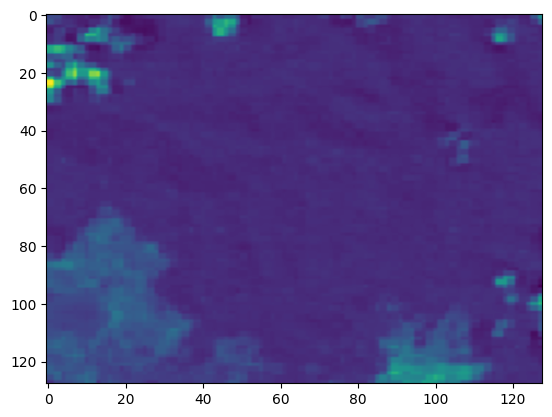

In [21]:
# Resizing the RGB image to 128x128. The original image size is 85x85, which is not ideal to work with, when training a CNN architecture

import cv2
n_samples = 1000
X_train = np.zeros((n_samples,85,85,3))

for i in range(n_samples):
  X_train[i,...] = np.transpose(dataset_merged_bands[i][0][0]['image'])

#resizing images to 128x128x3
X_train = np.array([cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC) for img in X_train])

plt.imshow(X_train[10,:,:,0],aspect='auto')



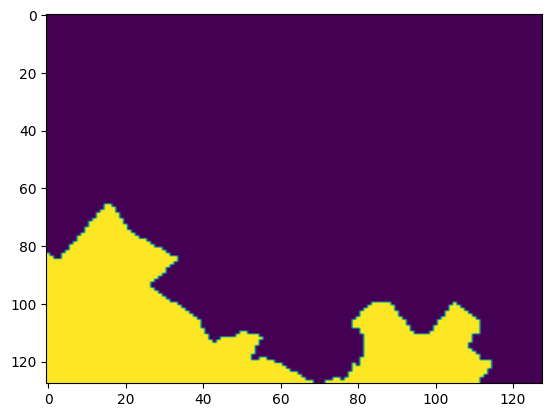

In [17]:
# Resizing the label image to 128x128, to match the RGB satellite image. The original label image size is 256x256
Y_train = np.zeros((n_samples,256,256,1))

for i in range(n_samples):
  Y_train[i,...] = np.transpose(dataset_merged_bands[i][1]['image'])

#resizing images to 128x128x3
Y_train = np.array([cv2.resize(img, (128, 128), interpolation=cv2.INTER_NEAREST) for img in Y_train])

plt.imshow(Y_train[10,:,:],aspect='auto')

In [22]:
np.save("/content/drive/MyDrive/CS230_data/deforestation_segmentation/X_train", X_train)
np.save("/content/drive/MyDrive/CS230_data/deforestation_segmentation/Y_train", Y_train)

# **Setting up the baseline U-Net Implementation**

The implementation for the basline U-Net architecture has been adopted from Carvana Image Masking Challenge. Link to GitHub repo: [https://github.com/milesial/Pytorch-UNet/tree/master](https://github.com/milesial/Pytorch-UNet/tree/master)

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet.git
%cd Pytorch-Unet
!pip install .

In [ ]:
X_train = np.load('/content/drive/MyDrive/CS230_data/deforestation_segmentation/X_train.npy')
Y_train = np.load('/content/drive/MyDrive/CS230_data/deforestation_segmentation/Y_train.npy')

In [ ]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from evaluate import evaluate
from unet import UNet
from utils.data_loading import BasicDataset, CarvanaDataset


dir_img = Path('/content/drive/MyDrive/CS230_data/deforestation_segmentation/X_train.npy')
dir_mask = Path('/content/drive/MyDrive/CS230_data/deforestation_segmentation/Y_train.npy')
dir_checkpoint = Path('./checkpoints/')


def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    # 1. Create dataset
    try:
        dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()


if __name__ == '__main__':
    args = get_args()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
    model = model.to(memory_format=torch.channels_last)

    logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

    if args.load:
        state_dict = torch.load(args.load, map_location=device)
        del state_dict['mask_values']
        model.load_state_dict(state_dict)
        logging.info(f'Model loaded from {args.load}')

    model.to(device=device)
    try:
        train_model(
            model=model,
            epochs=args.epochs,
            batch_size=args.batch_size,
            learning_rate=args.lr,
            device=device,
            img_scale=args.scale,
            val_percent=args.val / 100,
            amp=args.amp
        )
    except torch.cuda.OutOfMemoryError:
        logging.error('Detected OutOfMemoryError! '
                      'Enabling checkpointing to reduce memory usage, but this slows down training. '
                      'Consider enabling AMP (--amp) for fast and memory efficient training')
        torch.cuda.empty_cache()
        model.use_checkpointing()
        train_model(
            model=model,
            epochs=args.epochs,
            batch_size=args.batch_size,
            learning_rate=args.lr,
            device=device,
            img_scale=args.scale,
            val_percent=args.val / 100,
            amp=args.amp
        )